# Group 16: LDA Application for Unsupervised Topic Modelling

In [58]:
import json
import pandas as pd
import numpy as np
import re
import sys
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from rake_nltk import Rake
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [59]:
df_og = pd.read_csv('dropped_Tesla_contents_cleaned.csv')
df_og.head()

,date,time,username,tweet,replies_count,retweets_count,likes_count
0,8/4/2022,12:55:10,prydlakowski,tesla giga rodeo my prediction from last year was again spot on,0.0,0.0,0.0
1,8/4/2022,12:55:08,fannyfitch,can you provide a tesla for the drive,0.0,0.0,0.0
2,8/4/2022,12:55:05,betterknowyou,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,0.0,0.0,0.0
3,8/4/2022,12:55:03,datapronetwork,elon musk promises widespread rollout of tesla fsd beta this year,0.0,0.0,0.0
4,8/4/2022,12:55:03,melissa_vee,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,0.0,0.0,0.0


In [60]:
df = df_og['tweet'].to_frame().dropna()
display(df)

,tweet
0,tesla giga rodeo my prediction from last year was again spot on
1,can you provide a tesla for the drive
2,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as
3,elon musk promises widespread rollout of tesla fsd beta this year
4,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have
...,...
71021,so your plan upon finding video footage of your neighbor keying your car is to immediately murder them seems like giving up the high ground
71022,tesla scalps
71023,almost but didnt a year ago with old version
71024,i cant wait for anything negative about tesla or elon to have a disclaimer that says this source is an opinion piece and not factually credible


In [61]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string
df['remove_lower_punct'] = df['tweet'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.strip()
display(df.head(10))

,tweet,remove_lower_punct
0,tesla giga rodeo my prediction from last year was again spot on,tesla giga rodeo my prediction from last year was again spot on
1,can you provide a tesla for the drive,can you provide a tesla for the drive
2,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as
3,elon musk promises widespread rollout of tesla fsd beta this year,elon musk promises widespread rollout of tesla fsd beta this year
4,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have
5,man i missed you,man i missed you
6,cool,cool
7,jeep says its new electric wrangler suv concept is as fast as atesla,jeep says its new electric wrangler suv concept is as fast as atesla
8,market has been oversold for days and we double bottomed on the h chart also hype from tesla factory,market has been oversold for days and we double bottomed on the h chart also hype from tesla factory
9,in todays tesla rodeo event,in todays tesla rodeo event


In [62]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list

display(df.head(10))

,tweet,remove_lower_punct,sentiment,sentiment score
0,tesla giga rodeo my prediction from last year was again spot on,tesla giga rodeo my prediction from last year was again spot on,Neutral,0.0000
1,can you provide a tesla for the drive,can you provide a tesla for the drive,Neutral,0.0000
2,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,Positive,0.3818
3,elon musk promises widespread rollout of tesla fsd beta this year,elon musk promises widespread rollout of tesla fsd beta this year,Positive,0.3818
4,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,Positive,0.3818
5,man i missed you,man i missed you,Negative,-0.2960
6,cool,cool,Positive,0.3182
7,jeep says its new electric wrangler suv concept is as fast as atesla,jeep says its new electric wrangler suv concept is as fast as atesla,Neutral,0.0000
8,market has been oversold for days and we double bottomed on the h chart also hype from tesla factory,market has been oversold for days and we double bottomed on the h chart also hype from tesla factory,Neutral,0.0000
9,in todays tesla rodeo event,in todays tesla rodeo event,Neutral,0.0000


In [63]:
df['tokenise'] = df.apply(lambda row: nltk.word_tokenize(row[1]), axis=1)
display(df.head(10))

,tweet,remove_lower_punct,sentiment,sentiment score,tokenise
0,tesla giga rodeo my prediction from last year was again spot on,tesla giga rodeo my prediction from last year was again spot on,Neutral,0.0000,"[tesla, giga, rodeo, my, prediction, from, last, year, was, again, spot, on]"
1,can you provide a tesla for the drive,can you provide a tesla for the drive,Neutral,0.0000,"[can, you, provide, a, tesla, for, the, drive]"
2,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year, tesla, ceo, elon, musk, said, thursday, night, the, company, plans, to, roll, out, this, year, its, full, self, driving, beta, software, to, all, customers, in, north, america, who, have, plunked, down, as, much, as]"
3,elon musk promises widespread rollout of tesla fsd beta this year,elon musk promises widespread rollout of tesla fsd beta this year,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year]"
4,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year, tesla, ceo, elon, musk, said, thursday, night, the, company, plans, to, roll, out, this, year, its, full, self, driving, beta, software, to, all, customers, in, north, america, who, have]"
5,man i missed you,man i missed you,Negative,-0.2960,"[man, i, missed, you]"
6,cool,cool,Positive,0.3182,[cool]
7,jeep says its new electric wrangler suv concept is as fast as atesla,jeep says its new electric wrangler suv concept is as fast as atesla,Neutral,0.0000,"[jeep, says, its, new, electric, wrangler, suv, concept, is, as, fast, as, atesla]"
8,market has been oversold for days and we double bottomed on the h chart also hype from tesla factory,market has been oversold for days and we double bottomed on the h chart also hype from tesla factory,Neutral,0.0000,"[market, has, been, oversold, for, days, and, we, double, bottomed, on, the, h, chart, also, hype, from, tesla, factory]"
9,in todays tesla rodeo event,in todays tesla rodeo event,Neutral,0.0000,"[in, todays, tesla, rodeo, event]"


In [64]:
# initiate stopwords
stop_words = stopwords.words('english')

# remove stopwords
df['remove_stopwords'] = df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])
display(df.head(5))

,tweet,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords
0,tesla giga rodeo my prediction from last year was again spot on,tesla giga rodeo my prediction from last year was again spot on,Neutral,0.0000,"[tesla, giga, rodeo, my, prediction, from, last, year, was, again, spot, on]","[tesla, giga, rodeo, prediction, last, year, spot]"
1,can you provide a tesla for the drive,can you provide a tesla for the drive,Neutral,0.0000,"[can, you, provide, a, tesla, for, the, drive]","[provide, tesla, drive]"
2,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year, tesla, ceo, elon, musk, said, thursday, night, the, company, plans, to, roll, out, this, year, its, full, self, driving, beta, software, to, all, customers, in, north, america, who, have, plunked, down, as, much, as]","[elon, musk, promises, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plans, roll, year, full, self, driving, beta, software, customers, north, america, plunked, much]"
3,elon musk promises widespread rollout of tesla fsd beta this year,elon musk promises widespread rollout of tesla fsd beta this year,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year]","[elon, musk, promises, widespread, rollout, tesla, fsd, beta, year]"
4,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year, tesla, ceo, elon, musk, said, thursday, night, the, company, plans, to, roll, out, this, year, its, full, self, driving, beta, software, to, all, customers, in, north, america, who, have]","[elon, musk, promises, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plans, roll, year, full, self, driving, beta, software, customers, north, america]"


In [65]:
# lemmatise words
wordnet_lemmatizer = WordNetLemmatizer()
df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 
display(df.head(10))

,tweet,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise
0,tesla giga rodeo my prediction from last year was again spot on,tesla giga rodeo my prediction from last year was again spot on,Neutral,0.0000,"[tesla, giga, rodeo, my, prediction, from, last, year, was, again, spot, on]","[tesla, giga, rodeo, prediction, last, year, spot]","[tesla, giga, rodeo, prediction, last, year, spot]"
1,can you provide a tesla for the drive,can you provide a tesla for the drive,Neutral,0.0000,"[can, you, provide, a, tesla, for, the, drive]","[provide, tesla, drive]","[provide, tesla, drive]"
2,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year, tesla, ceo, elon, musk, said, thursday, night, the, company, plans, to, roll, out, this, year, its, full, self, driving, beta, software, to, all, customers, in, north, america, who, have, plunked, down, as, much, as]","[elon, musk, promises, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plans, roll, year, full, self, driving, beta, software, customers, north, america, plunked, much]","[elon, musk, promise, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plan, roll, year, full, self, driving, beta, software, customer, north, america, plunked, much]"
3,elon musk promises widespread rollout of tesla fsd beta this year,elon musk promises widespread rollout of tesla fsd beta this year,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year]","[elon, musk, promises, widespread, rollout, tesla, fsd, beta, year]","[elon, musk, promise, widespread, rollout, tesla, fsd, beta, year]"
4,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year, tesla, ceo, elon, musk, said, thursday, night, the, company, plans, to, roll, out, this, year, its, full, self, driving, beta, software, to, all, customers, in, north, america, who, have]","[elon, musk, promises, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plans, roll, year, full, self, driving, beta, software, customers, north, america]","[elon, musk, promise, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plan, roll, year, full, self, driving, beta, software, customer, north, america]"
5,man i missed you,man i missed you,Negative,-0.2960,"[man, i, missed, you]","[man, missed]","[man, missed]"
6,cool,cool,Positive,0.3182,[cool],[cool],[cool]
7,jeep says its new electric wrangler suv concept is as fast as atesla,jeep says its new electric wrangler suv concept is as fast as atesla,Neutral,0.0000,"[jeep, says, its, new, electric, wrangler, suv, concept, is, as, fast, as, atesla]","[jeep, says, new, electric, wrangler, suv, concept, fast, atesla]","[jeep, say, new, electric, wrangler, suv, concept, fast, atesla]"
8,market has been oversold for days and we double bottomed on the h chart als

In [66]:
# initialise the count vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
                            
# join the processed data to be vectorised
vectors = []

for index, row in df.iterrows():
    vectors.append(", ".join(row[6]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)

  (0, 359383)	1
  (0, 147501)	1
  (0, 304950)	1
  (0, 276830)	1
  (0, 195824)	1
  (0, 418138)	1
  (1, 283883)	1
  (1, 358672)	1
  (2, 108199)	2
  (2, 237958)	1
  (2, 282641)	1
  (2, 407555)	1
  (2, 305326)	1
  (2, 359282)	1
  (2, 139317)	1
  (2, 34811)	1
  (2, 418185)	1
  (2, 357930)	1
  (2, 57933)	1
  (2, 238118)	1
  (2, 308467)	1
  (2, 371247)	1
  (2, 246372)	1
  (2, 69993)	1
  (2, 269268)	1
  :	:
  (71019, 176459)	1
  (71019, 236619)	1
  (71020, 361908)	1
  (71021, 417310)	1
  (71021, 9397)	1
  (71021, 252152)	1
  (71021, 6933)	1
  (71021, 92906)	1
  (71022, 358788)	1
  (71022, 52326)	1
  (71022, 242568)	1
  (71022, 310816)	1
  (71022, 17554)	1
  (71022, 332524)	1
  (71022, 398711)	1
  (71022, 107743)	1
  (71022, 94711)	1
  (71022, 254971)	1
  (71022, 268008)	1
  (71022, 125019)	1
  (71023, 359428)	1
  (71023, 291853)	1
  (71023, 416706)	1
  (71023, 151119)	1
  (71023, 386894)	1


In [67]:
# initisalise LDA Model
lda_model = LatentDirichletAllocation(n_components = 5, random_state = 10, evaluate_every = -1, n_jobs = -1)
lda_output = lda_model.fit_transform(vectorised)

# column names
topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document
dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes
df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
display(df.head(10))

,tweet,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5,Dominant_topic
0,tesla giga rodeo my prediction from last year was again spot on,tesla giga rodeo my prediction from last year was again spot on,Neutral,0.0000,"[tesla, giga, rodeo, my, prediction, from, last, year, was, again, spot, on]","[tesla, giga, rodeo, prediction, last, year, spot]","[tesla, giga, rodeo, prediction, last, year, spot]",0.03,0.03,0.88,0.03,0.03,3.0
1,can you provide a tesla for the drive,can you provide a tesla for the drive,Neutral,0.0000,"[can, you, provide, a, tesla, for, the, drive]","[provide, tesla, drive]","[provide, tesla, drive]",0.72,0.07,0.07,0.07,0.07,1.0
2,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have plunked down as much as,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year, tesla, ceo, elon, musk, said, thursday, night, the, company, plans, to, roll, out, this, year, its, full, self, driving, beta, software, to, all, customers, in, north, america, who, have, plunked, down, as, much, as]","[elon, musk, promises, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plans, roll, year, full, self, driving, beta, software, customers, north, america, plunked, much]","[elon, musk, promise, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plan, roll, year, full, self, driving, beta, software, customer, north, america, plunked, much]",0.59,0.39,0.01,0.01,0.01,1.0
3,elon musk promises widespread rollout of tesla fsd beta this year,elon musk promises widespread rollout of tesla fsd beta this year,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year]","[elon, musk, promises, widespread, rollout, tesla, fsd, beta, year]","[elon, musk, promise, widespread, rollout, tesla, fsd, beta, year]",0.02,0.91,0.02,0.02,0.02,2.0
4,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,elon musk promises widespread rollout of tesla fsd beta this year tesla ceo elon musk said thursday night the company plans to roll out this year its full self driving beta software to all customers in north america who have,Positive,0.3818,"[elon, musk, promises, widespread, rollout, of, tesla, fsd, beta, this, year, tesla, ceo, elon, musk, said, thursday, night, the, company, plans, to, roll, out, this, year, its, full, self, driving, beta, software, to, all, customers, in, north, america, who, have]","[elon, musk, promises, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plans, roll, year, full, self, driving, beta, software, customers, north, america]","[elon, musk, promise, widespread, rollout, tesla, fsd, beta, year, tesla, ceo, elon, musk, said, thursday, night, company, plan, roll, year, full, self, driving, beta, software, customer, north, america]",0.54,0.44,0.01,0.01,0.01,1.0
5,man i missed you,man i missed you,Negative,-0.2960,"[man, i, missed, you]","[man, missed]","[man, missed]",0.10,0.10,0.60,0.10,0.10,3.0
6,cool,cool,Positive,0.3182,[cool],[cool],[cool],0.20,0.20,0.20,0.20,0.20,1.0
7,jeep says its new electric wrangler suv concept is as fast as atesla,jeep says its new electric wrangler suv concept is as fast as atesla,Neutral,0.0000,"[jeep, says, its, new, electric, wrangler, 

In [68]:
# index names
docnames = ['Doc' + str(i) for i in range(len(df_document_topic))] 

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

,topic,relevance_score
03 south,Topic1,1.199994
04 happy,Topic5,1.199919
04 tesla,Topic2,1.201594
05 tesla,Topic4,1.187119
06 ark,Topic2,1.199990
...,...,...
zwickau germany,Topic3,1.199994
zwnav inch,Topic2,1.199994
zws elon,Topic2,1.199989
zyada pricing,Topic4,1.199988


# Dominant Topics

In [69]:
pd.set_option('display.max_colwidth', None)

In [70]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    tmp_1['topic'] = tmp_1['topic']
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'], )
# To merge below, need to change 'Dominant_topic' from 'Topic1' in all_topics to '1.0' in results
all_topics['Dominant_topic'] = all_topics['Dominant_topic'].apply(lambda x: float(x[-1]))
display(all_topics)

,Dominant_topic,topic_name
0,1.0,[tesla model]
1,5.0,[cyber rodeo]
2,2.0,[elon musk]
3,4.0,[like tesla]
4,3.0,[giga texas]


In [71]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

sentiment,Negative,Neutral,Positive
topic_name,,,
cyber rodeo,3160,4331,6380
elon musk,3143,4222,6535
giga texas,2933,4169,6272
like tesla,3145,4255,6618
tesla model,3405,5224,7230


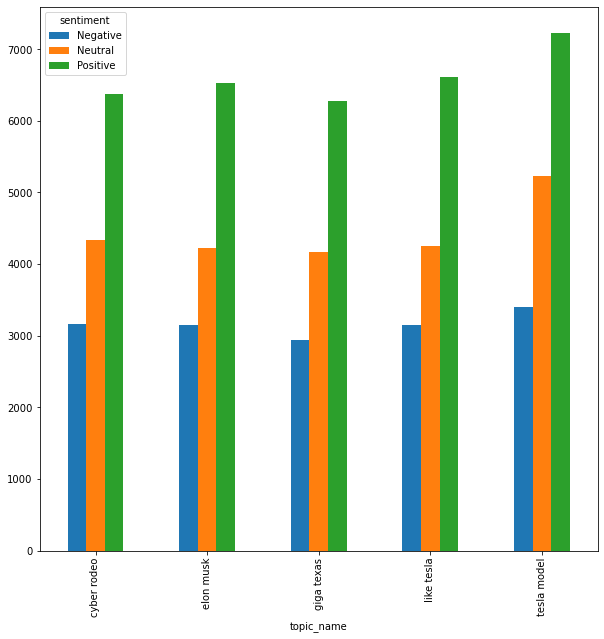

In [72]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))
fig.figure.savefig('sentiment_analysis.png', bbox_inches='tight')